In [1]:
import scipy.io as sio
import dotenv
import os
import numpy as np
import umap
from sklearn.decomposition import PCA

from scipy.signal import butter, filtfilt, hilbert, stft, detrend


from util import plot_barcode
import matplotlib.pyplot as plt

from ripser import ripser
from persim import plot_diagrams, wasserstein

dotenv.load_dotenv()

INPUT_FOLDER = os.getenv("INPUT_FOLDER")

/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import mne
from mne_bids import BIDSPath

import gudhi as gd
from gudhi.representations import PersistenceImage
import numpy as np

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


# Data visualization

## Utils

In [3]:
def convert_mat_to_mne(data_dict):
    """
    Converts CRCNS/Matlab ECoG dict to an MNE Raw object.
    Truth: MNE requires data as (n_channels, n_times).
    """
    # 1. Extract raw data and sampling rate
    # Filter out metadata keys that scipy.io.loadmat adds
    data = data_dict["ECoG"]  # Shape likely (samples, channels)
    fs = float(data_dict["Fs"].squeeze())

    # 2. Transpose to MNE format: (channels, samples)
    # This is a critical mathematical step for memory alignment
    data_t = data.T

    # 3. Convert to float32 for MNE compatibility (more memory efficient)
    if data_t.dtype != np.float32:
        data_t = data_t.astype(np.float32)

    n_channels = data_t.shape[0]

    # 4. Create metadata (Info object)
    # We define channel types as 'ecog' for specialized processing
    ch_names = [f"ECoG_{i}" for i in range(n_channels)]
    info = mne.create_info(ch_names=ch_names, sfreq=fs, ch_types="ecog")

    # 5. Create the MNE Raw object
    raw = mne.io.RawArray(data_t, info)

    # 6. Set measurement date to None for anonymous ECoG data
    # Use set_meas_date() method instead of direct assignment
    raw.set_meas_date(None)

    return raw


def ecog_filter(data, lowcut=70, highcut=200):
    raw = convert_mat_to_mne(data)

    psd = raw.compute_psd(picks="ecog")
    fig = psd.plot()

    raw.load_data()  # required
    rereferenced_raw = raw.set_eeg_reference(ref_channels="average", ch_type="ecog")
    powerline_freq = raw.info.get("line_freq")
    if powerline_freq is None:
        powerline_freq = 50
    freqs = [powerline_freq * m for m in range(1, 4)]
    notched_raw = rereferenced_raw.notch_filter(freqs=freqs, notch_widths=2)
    iir_params = dict(order=4, ftype="butter")
    band_raw = notched_raw.filter(
        lowcut, highcut, picks="data", method="iir", iir_params=iir_params
    )
    band_raw = band_raw.apply_hilbert(envelope=True)
    psd = band_raw.compute_psd(picks="ecog")
    fig = psd.plot()

    return band_raw.get_data().T


def extract_principal_components(data, gamma="High"):
    pca_full = PCA(n_components=min(data.shape[0], data.shape[1]))
    data_pca_full = pca_full.fit_transform(data)
    explained_var = pca_full.explained_variance_ratio_

    plt.figure(figsize=(6, 4))
    plt.plot(
        np.arange(1, len(explained_var) + 1), np.cumsum(explained_var) * 100, marker="o"
    )
    plt.xlabel("Number of Principal Components")
    plt.ylabel("Cumulative Explained Variance (%)")
    plt.title(f"Bilateral PCA Cumulative Explained Variance {gamma} Gamma")
    plt.grid(True)
    plt.show()

    # Apply PCA, retain first 6 principal components
    n_components = np.max([np.argmax(np.cumsum(explained_var) > 0.9) + 1, 3])
    pca = PCA(n_components=n_components)
    data_pca = pca.fit_transform(data)

    print(
        f"Explained variance by first {n_components} PCs:",
        np.sum(pca.explained_variance_ratio_),
    )

    return data_pca


def extract_umap(data_pca, gamma="High"):
    umap_reducer = umap.UMAP(n_components=3, random_state=42)
    data_umap = umap_reducer.fit_transform(data_pca[::10])  # shape: (n_samples, 3)

    fig = plt.figure(figsize=(18, 5))
    angles = [(30, 45), (10, 120), (80, 200)]  # List of (elev, azim)

    fig.suptitle(
        f"Bilateral ECoG: 3D UMAP Embedding (Various Views), {gamma} Gamma",
        fontsize=16,
        y=1.03,
    )

    for i, (elev, azim) in enumerate(angles):
        ax = fig.add_subplot(1, len(angles), i + 1, projection="3d")
        ax.scatter(
            data_umap[:, 0], data_umap[:, 1], data_umap[:, 2], s=1, c="navy", alpha=0.5
        )
        ax.set_title(f"View elev={elev}, azim={azim}")
        ax.set_xlabel("UMAP1")
        ax.set_ylabel("UMAP2")
        ax.set_zlabel("UMAP3")
        ax.view_init(elev=elev, azim=azim)

    plt.tight_layout()
    plt.show()

    return data_umap


def extract_barcodes(data, gamma="High"):
    print(data.shape, gamma)
    maxdim = 2
    diagrams = ripser(data, maxdim=maxdim)["dgms"]

    # Show both persistence diagrams and barcodes (lifetimes)
    plot_diagrams(diagrams, show=True)
    plot_barcode(diagrams)

    plt.tight_layout()
    plt.show()

## Bilateral

In [4]:
data = sio.loadmat(f"{INPUT_FOLDER}/CRCNS/Bilateral/2018-07-12_(S1)/ECoG.mat")

# Concatenate all ecog arrays along the time/sample axis
ecog = data["ECoG"]
time = data["ECoG_time"]
fs = float(data["Fs"].squeeze())  # Sampling frequency

Creating RawArray with float64 data, n_channels=64, n_times=1024398
    Range : 0 ... 1024397 =      0.000 ...  1024.397 secs
Ready.
Effective window size : 2.048 (s)
Plotting power spectral density (dB=True).
Applying average reference.
Applying a custom ('ECoG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)



/var/folders/9d/c4dhgfyd2d3gpx7vnj3kdyyr0000gn/T/ipykernel_22692/1191338440.py:40: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  fig = psd.plot()
/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/mne/viz/utils.py:160: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 100.00 Hz: -6.02, -6.02 dB

Effective window size : 2.048 (s)
Plotting power spectral density (dB=True).


/var/folders/9d/c4dhgfyd2d3gpx7vnj3kdyyr0000gn/T/ipykernel_22692/1191338440.py:55: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  fig = psd.plot()
/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/mne/viz/utils.py:160: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


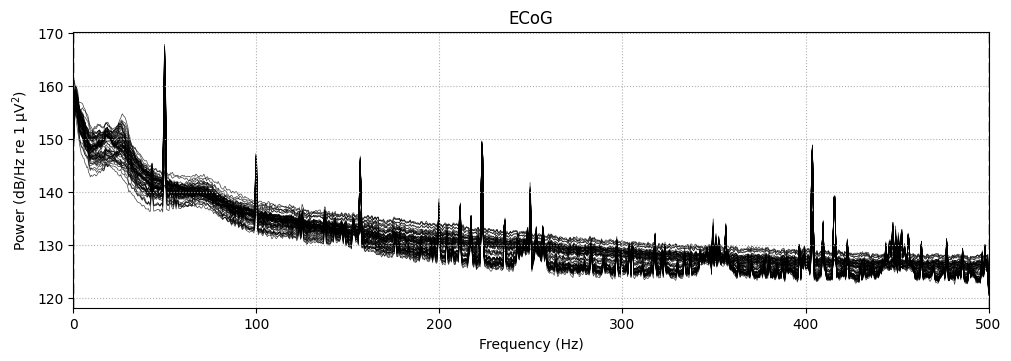

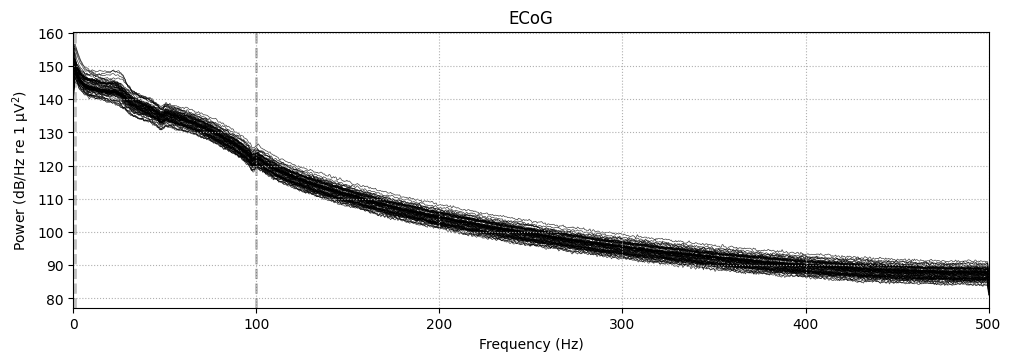

In [5]:
preprocessed_ecog = ecog_filter(data, lowcut=1, highcut=100)

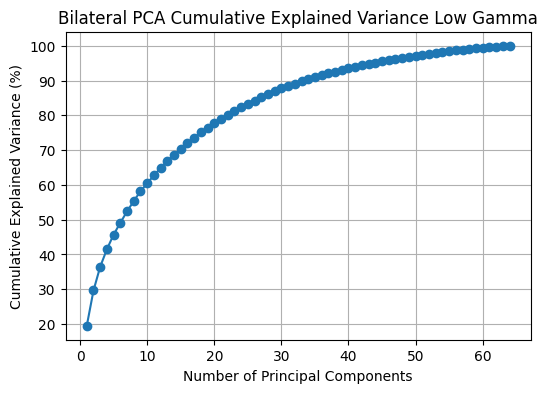

Explained variance by first 34 PCs: 0.9036366479063305


/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


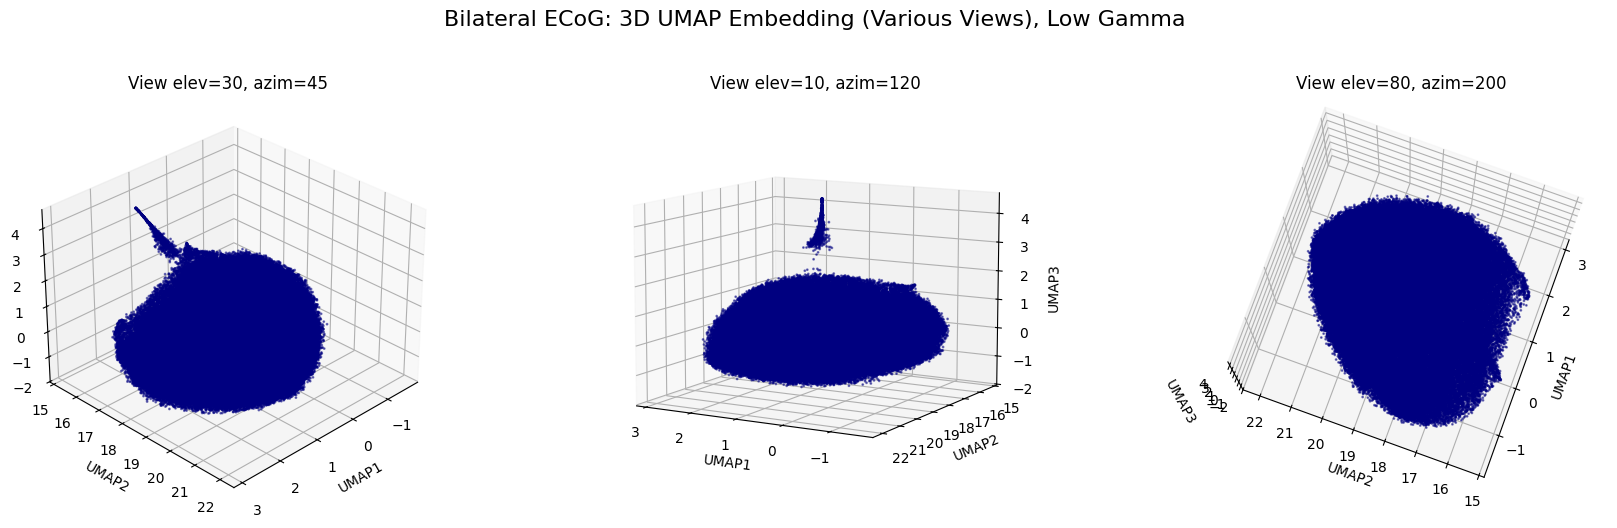

In [ ]:
data_pca = extract_principal_components(preprocessed_ecog, gamma="Low")
data_umap = extract_umap(data_pca, gamma="Low")

In [7]:
# extract_barcodes(data_umap[::100], gamma="Low")

## Contralateral

In [8]:
data = sio.loadmat(f"{INPUT_FOLDER}/CRCNS/Contralateral/2018-03-15_(S1)/ECoG.mat")

# Concatenate all ecog arrays along the time/sample axis
ecog = data["ECoG"]
time = data["ECoG_time"]
fs = float(data["Fs"].squeeze())  # Sampling frequency

In [9]:
preprocessed_ecog = ecog_filter(data, lowcut=1, highcut=100)

Creating RawArray with float64 data, n_channels=64, n_times=907298
    Range : 0 ... 907297 =      0.000 ...   907.297 secs
Ready.
Effective window size : 2.048 (s)
Plotting power spectral density (dB=True).
Applying average reference.
Applying a custom ('ECoG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)



/var/folders/9d/c4dhgfyd2d3gpx7vnj3kdyyr0000gn/T/ipykernel_21268/1191338440.py:40: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  fig = psd.plot()
/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/mne/viz/utils.py:160: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 100.00 Hz: -6.02, -6.02 dB

Effective window size : 2.048 (s)
Plotting power spectral density (dB=True).


/var/folders/9d/c4dhgfyd2d3gpx7vnj3kdyyr0000gn/T/ipykernel_21268/1191338440.py:55: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  fig = psd.plot()
/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/mne/viz/utils.py:160: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


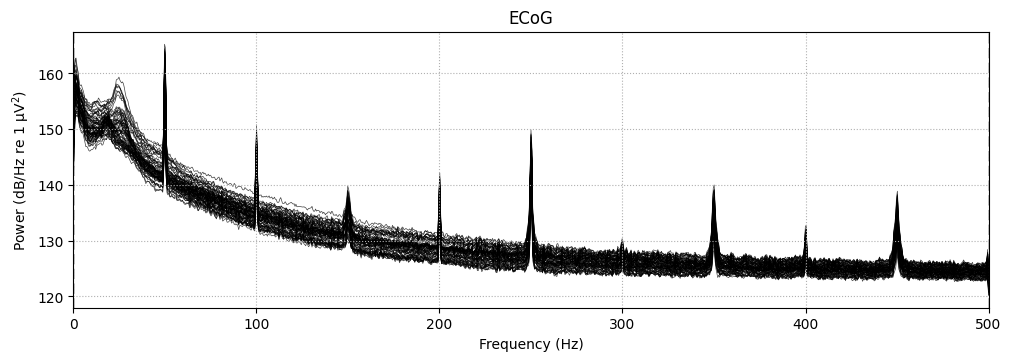

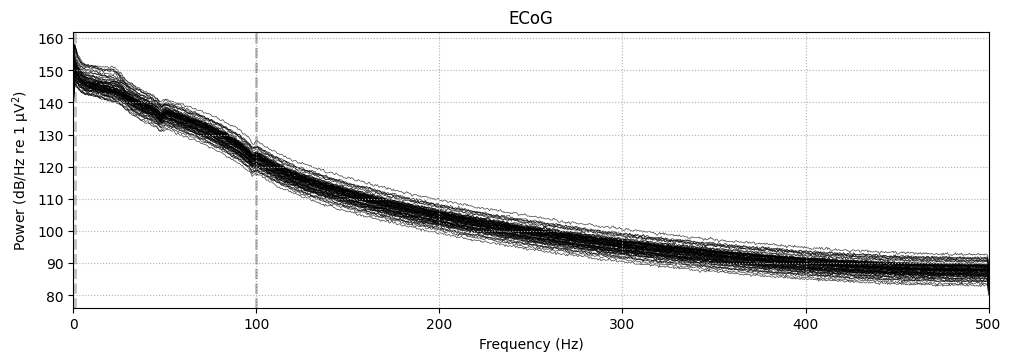

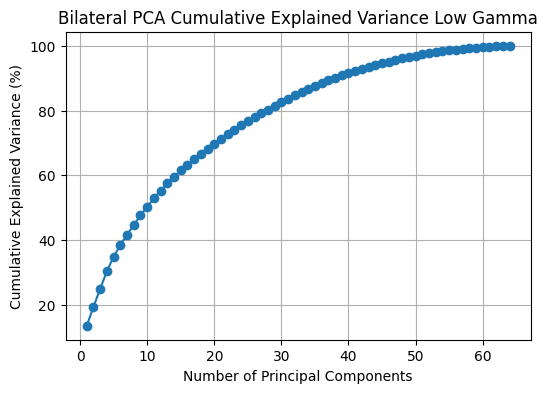

Explained variance by first 38 PCs: 0.900947539391313


/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


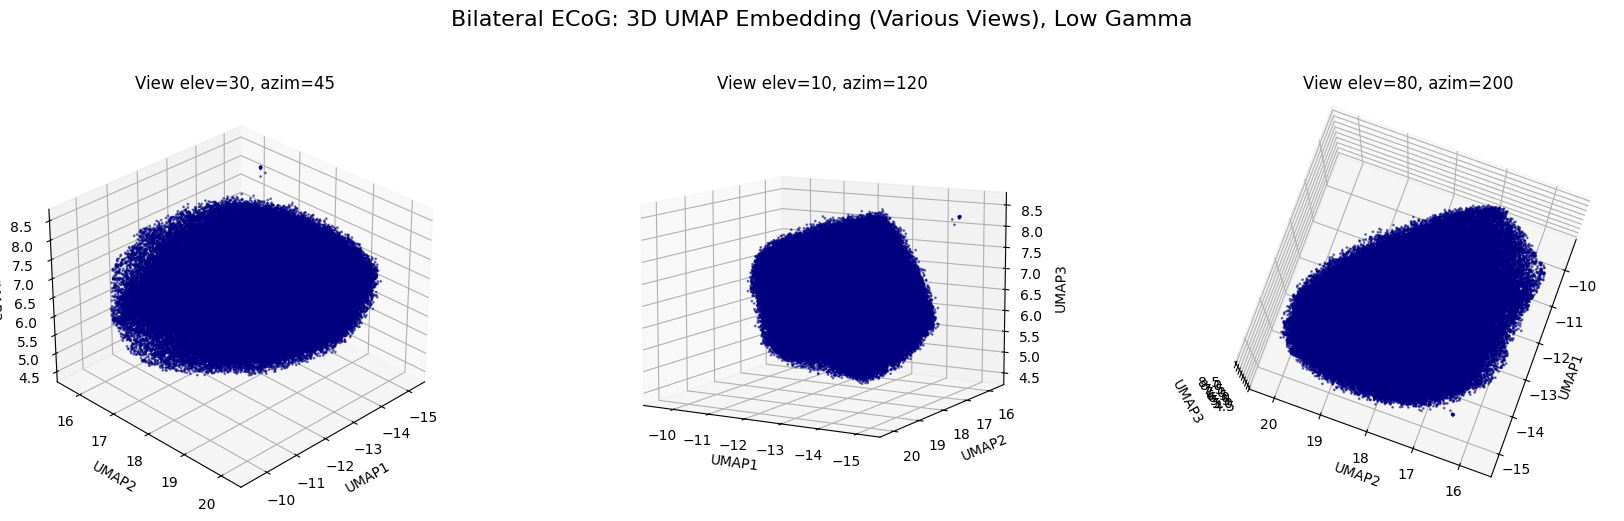

In [10]:
data_pca = extract_principal_components(preprocessed_ecog, gamma="Low")
data_umap = extract_umap(data_pca, gamma="Low")

In [11]:
# extract_barcodes(data_umap[::100], gamma="Low")

## Ipsilateral

In [12]:
data = sio.loadmat(f"{INPUT_FOLDER}/CRCNS/Ipsilateral/2018-04-29_(S1)/ECoG.mat")

# Concatenate all ecog arrays along the time/sample axis
ecog = data["ECoG"]
time = data["ECoG_time"]
fs = float(data["Fs"].squeeze())  # Sampling frequency

In [13]:
preprocessed_ecog = ecog_filter(data, lowcut=1, highcut=100)

Creating RawArray with float64 data, n_channels=64, n_times=920498
    Range : 0 ... 920497 =      0.000 ...   920.497 secs
Ready.
Effective window size : 2.048 (s)
Plotting power spectral density (dB=True).
Applying average reference.
Applying a custom ('ECoG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)



/var/folders/9d/c4dhgfyd2d3gpx7vnj3kdyyr0000gn/T/ipykernel_21268/1191338440.py:40: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  fig = psd.plot()
/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/mne/viz/utils.py:160: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 100.00 Hz: -6.02, -6.02 dB

Effective window size : 2.048 (s)
Plotting power spectral density (dB=True).


/var/folders/9d/c4dhgfyd2d3gpx7vnj3kdyyr0000gn/T/ipykernel_21268/1191338440.py:55: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  fig = psd.plot()
/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/mne/viz/utils.py:160: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


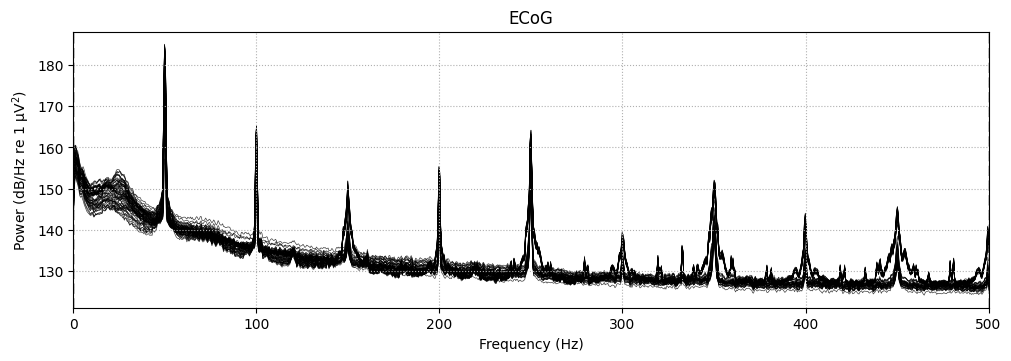

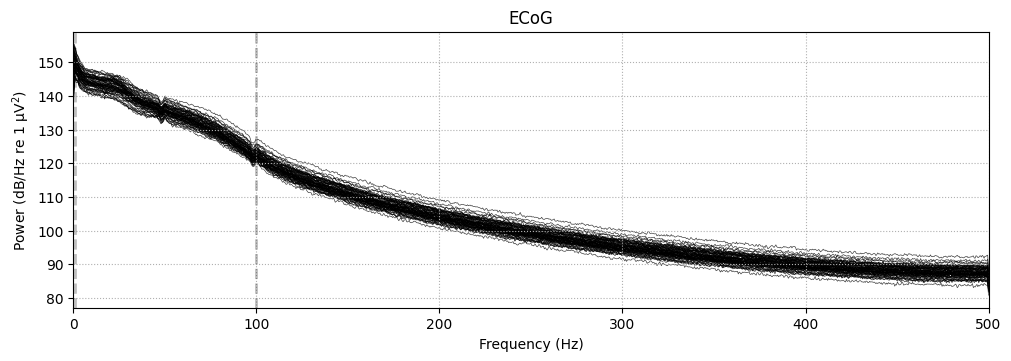

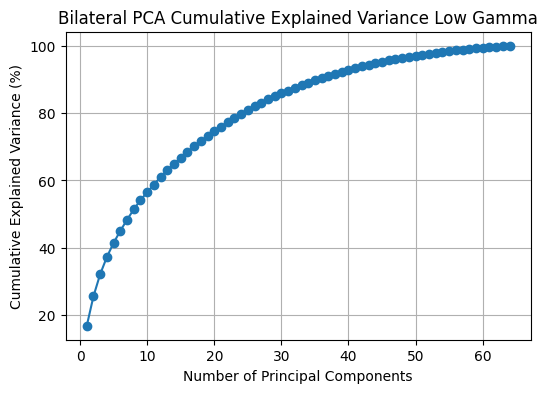

Explained variance by first 36 PCs: 0.9048025689996284


/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


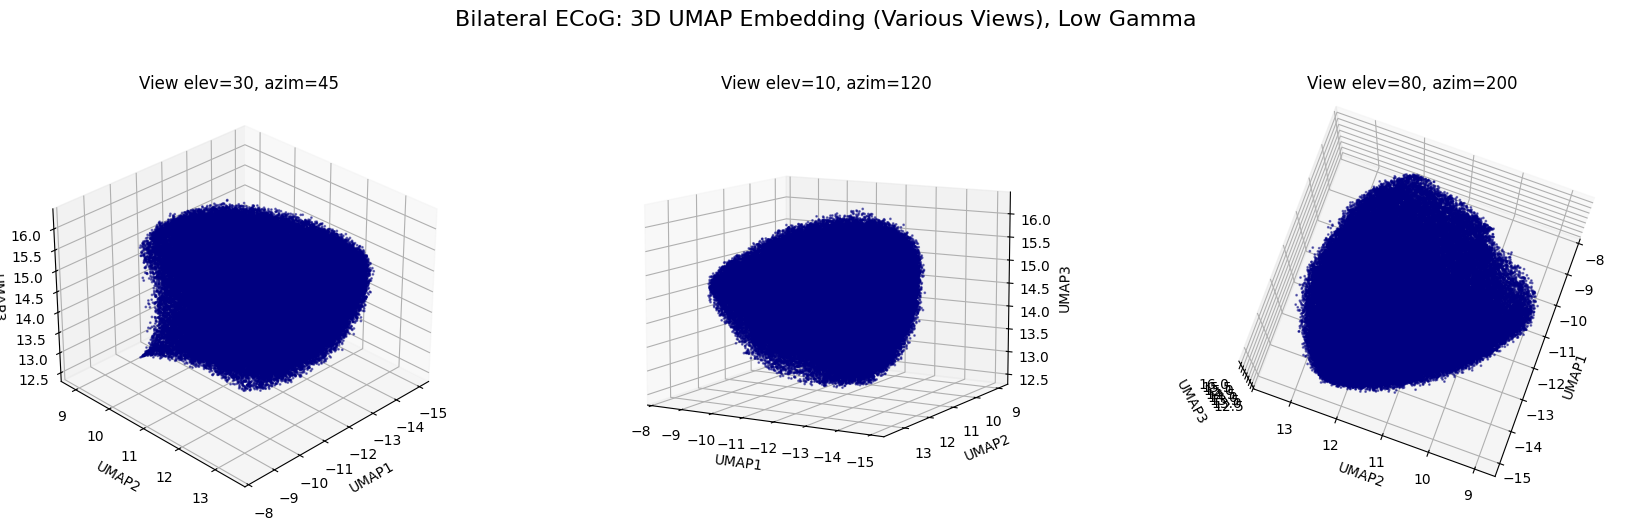

In [14]:
data_pca = extract_principal_components(preprocessed_ecog, gamma="Low")
data_umap = extract_umap(data_pca, gamma="Low")

In [15]:
# extract_barcodes(data_umap[::100], gamma="Low")

# GUDHI

## Utils

In [12]:
def preprocess_ecog(data, lowcut=70, highcut=200):
    raw = convert_mat_to_mne(data)

    raw.load_data()  # required
    rereferenced_raw = raw.set_eeg_reference(ref_channels="average", ch_type="ecog")
    powerline_freq = raw.info.get("line_freq")
    if powerline_freq is None:
        powerline_freq = 50
    freqs = [powerline_freq * m for m in range(1, 4)]
    notched_raw = rereferenced_raw.notch_filter(freqs=freqs, notch_widths=2)
    iir_params = dict(order=4, ftype="butter")
    band_raw = notched_raw.filter(
        lowcut, highcut, picks="data", method="iir", iir_params=iir_params
    )
    band_raw = band_raw.apply_hilbert(envelope=True)

    return band_raw.get_data().T


def project_ecog(ecog):
    # Apply PCA with enough components to explain >99% variance, and plot cumulative explained variance
    pca_full = PCA(n_components=min(ecog.shape[0], ecog.shape[1]))
    ecog_pca_full = pca_full.fit_transform(ecog)
    explained_var = pca_full.explained_variance_ratio_

    # Apply PCA, retain first 6 principal components
    n_components = np.argmax(np.cumsum(explained_var) > 0.9) + 1
    pca = PCA(n_components=n_components)
    ecog_pca = pca.fit_transform(ecog)

    umap_reducer = umap.UMAP(n_components=3, random_state=42)
    # Create 10 datasets with step of 10 (offsets 0, 1, ..., 9)
    ecog_umap = umap_reducer.fit_transform(ecog_pca[::10])

    return ecog_umap


## Create datasets

In [13]:
ipsi_data_list = [
    f"{INPUT_FOLDER}/CRCNS/Ipsilateral/2018-04-29_(S1)/ECoG.mat",
    f"{INPUT_FOLDER}/CRCNS/Ipsilateral/2018-04-29_(S2)/ECoG.mat",
    f"{INPUT_FOLDER}/CRCNS/Ipsilateral/2018-05-03_(S3)/ECoG.mat",
    f"{INPUT_FOLDER}/CRCNS/Ipsilateral/2018-05-03_(S4)/ECoG.mat",
    f"{INPUT_FOLDER}/CRCNS/Ipsilateral/2018-05-03_(S5)/ECoG.mat",
    f"{INPUT_FOLDER}/CRCNS/Ipsilateral/2018-05-06_(S6)/ECoG.mat",
    f"{INPUT_FOLDER}/CRCNS/Ipsilateral/2018-05-10_(S7)/ECoG.mat",
    f"{INPUT_FOLDER}/CRCNS/Ipsilateral/2018-05-10_(S8)/ECoG.mat",
    f"{INPUT_FOLDER}/CRCNS/Ipsilateral/2018-05-17_(S9)/ECoG.mat",
    f"{INPUT_FOLDER}/CRCNS/Ipsilateral/2018-05-24_(S10)/ECoG.mat",
]

contra_data_list = [
    f"{INPUT_FOLDER}/CRCNS/Contralateral/2018-03-15_(S1)/ECoG.mat",
    f"{INPUT_FOLDER}/CRCNS/Contralateral/2018-04-08_(S2)/ECoG.mat",
    f"{INPUT_FOLDER}/CRCNS/Contralateral/2018-04-12_(S3)/ECoG.mat",
    f"{INPUT_FOLDER}/CRCNS/Contralateral/2018-04-12_(S4)/ECoG.mat",
    f"{INPUT_FOLDER}/CRCNS/Contralateral/2018-04-12_(S5)/ECoG.mat",
    f"{INPUT_FOLDER}/CRCNS/Contralateral/2018-04-15_(S6)/ECoG.mat",
    f"{INPUT_FOLDER}/CRCNS/Contralateral/2018-04-22_(S7)/ECoG.mat",
    f"{INPUT_FOLDER}/CRCNS/Contralateral/2018-04-22_(S8)/ECoG.mat",
    f"{INPUT_FOLDER}/CRCNS/Contralateral/2018-04-22_(S9)/ECoG.mat",
    f"{INPUT_FOLDER}/CRCNS/Contralateral/2018-05-31_(S10)/ECoG.mat",
]

bilat_data_list = [
    f"{INPUT_FOLDER}/CRCNS/Bilateral/2018-07-12_(S1)/ECoG.mat",
    f"{INPUT_FOLDER}/CRCNS/Bilateral/2018-07-19_(S2)/ECoG.mat",
    f"{INPUT_FOLDER}/CRCNS/Bilateral/2018-07-26_(S3)/ECoG.mat",
    f"{INPUT_FOLDER}/CRCNS/Bilateral/2018-08-14_(S4)/ECoG.mat",
    f"{INPUT_FOLDER}/CRCNS/Bilateral/2018-09-27_(S5)/ECoG.mat",
    f"{INPUT_FOLDER}/CRCNS/Bilateral/2018-10-04_(S6)/ECoG.mat",
]

y = []  # labels: 0=ipsi, 1=contra, 2=bilat
all_h0_diagrams = []  # Collect all H1 diagrams to fit the imager
all_h1_diagrams = []  # Collect all H2 diagrams to fit the imager
all_h2_diagrams = []  # Collect all H3 diagrams to fit the imager

maxdim = 2
subsample_step = 100  # Subsample the projected data
offsets = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

print("Processing data and computing persistence diagrams...")

# Process Ipsilateral data
for data_path in ipsi_data_list:
    data = sio.loadmat(data_path)
    ecog_preprocessed = preprocess_ecog(data, lowcut=1, highcut=100)
    ecog_projected = project_ecog(ecog_preprocessed)

    # Subsample for computational efficiency
    for offset in offsets:
        data_subsampled = ecog_projected[offset::subsample_step]

        ac = gd.AlphaComplex(points=data_subsampled).create_simplex_tree()
        dgm = ac.persistence()

        all_h0_diagrams.append(ac.persistence_intervals_in_dimension(0))
        all_h1_diagrams.append(ac.persistence_intervals_in_dimension(1))
        all_h2_diagrams.append(ac.persistence_intervals_in_dimension(2))
        y.append(0)

    print(f"  Processed: {data_path.split('/')[-2]} (ipsi)")

# Process Contralateral data
for data_path in contra_data_list:
    data = sio.loadmat(data_path)
    ecog_preprocessed = preprocess_ecog(data, lowcut=1, highcut=100)
    ecog_projected = project_ecog(ecog_preprocessed)

    # Subsample for computational efficiency
    for offset in offsets:
        data_subsampled = ecog_projected[offset::subsample_step]

        ac = gd.AlphaComplex(points=data_subsampled).create_simplex_tree()
        dgm = ac.persistence()

        all_h0_diagrams.append(ac.persistence_intervals_in_dimension(0))
        all_h1_diagrams.append(ac.persistence_intervals_in_dimension(1))
        all_h2_diagrams.append(ac.persistence_intervals_in_dimension(2))
        y.append(1)

    print(f"  Processed: {data_path.split('/')[-2]} (contra)")

# Process Bilateral data
for data_path in bilat_data_list:
    data = sio.loadmat(data_path)
    ecog_preprocessed = preprocess_ecog(data, lowcut=1, highcut=100)
    ecog_projected = project_ecog(ecog_preprocessed)

    # Subsample for computational efficiency
    for offset in offsets:
        data_subsampled = ecog_projected[offset::subsample_step]

        ac = gd.AlphaComplex(points=data_subsampled).create_simplex_tree()
        dgm = ac.persistence()

        all_h0_diagrams.append(ac.persistence_intervals_in_dimension(0))
        all_h1_diagrams.append(ac.persistence_intervals_in_dimension(1))
        all_h2_diagrams.append(ac.persistence_intervals_in_dimension(2))
        y.append(2)

    print(f"  Processed: {data_path.split('/')[-2]} (bilat)")

Processing data and computing persistence diagrams...
Creating RawArray with float64 data, n_channels=64, n_times=920498
    Range : 0 ... 920497 =      0.000 ...   920.497 secs
Ready.
Applying average reference.
Applying a custom ('ECoG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 100.00 Hz: -6.02, -6.02 dB



/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Processed: 2018-04-29_(S1) (ipsi)
Creating RawArray with float64 data, n_channels=64, n_times=1033898
    Range : 0 ... 1033897 =      0.000 ...  1033.897 secs
Ready.
Applying average reference.
Applying a custom ('ECoG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 100.00 Hz: -6.02, -6.02 dB



/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Processed: 2018-04-29_(S2) (ipsi)
Creating RawArray with float64 data, n_channels=64, n_times=945398
    Range : 0 ... 945397 =      0.000 ...   945.397 secs
Ready.
Applying average reference.
Applying a custom ('ECoG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 100.00 Hz: -6.02, -6.02 dB



/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Processed: 2018-05-03_(S3) (ipsi)
Creating RawArray with float64 data, n_channels=64, n_times=925198
    Range : 0 ... 925197 =      0.000 ...   925.197 secs
Ready.
Applying average reference.
Applying a custom ('ECoG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 100.00 Hz: -6.02, -6.02 dB



/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Processed: 2018-05-03_(S4) (ipsi)
Creating RawArray with float64 data, n_channels=64, n_times=928498
    Range : 0 ... 928497 =      0.000 ...   928.497 secs
Ready.
Applying average reference.
Applying a custom ('ECoG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 100.00 Hz: -6.02, -6.02 dB



/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Processed: 2018-05-03_(S5) (ipsi)
Creating RawArray with float64 data, n_channels=64, n_times=936998
    Range : 0 ... 936997 =      0.000 ...   936.997 secs
Ready.
Applying average reference.
Applying a custom ('ECoG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 100.00 Hz: -6.02, -6.02 dB



/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Processed: 2018-05-06_(S6) (ipsi)
Creating RawArray with float64 data, n_channels=64, n_times=939698
    Range : 0 ... 939697 =      0.000 ...   939.697 secs
Ready.
Applying average reference.
Applying a custom ('ECoG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 100.00 Hz: -6.02, -6.02 dB



/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Processed: 2018-05-10_(S7) (ipsi)
Creating RawArray with float64 data, n_channels=64, n_times=926698
    Range : 0 ... 926697 =      0.000 ...   926.697 secs
Ready.
Applying average reference.
Applying a custom ('ECoG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 100.00 Hz: -6.02, -6.02 dB



/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Processed: 2018-05-10_(S8) (ipsi)
Creating RawArray with float64 data, n_channels=64, n_times=929898
    Range : 0 ... 929897 =      0.000 ...   929.897 secs
Ready.
Applying average reference.
Applying a custom ('ECoG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 100.00 Hz: -6.02, -6.02 dB



/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Processed: 2018-05-17_(S9) (ipsi)
Creating RawArray with float64 data, n_channels=64, n_times=927998
    Range : 0 ... 927997 =      0.000 ...   927.997 secs
Ready.
Applying average reference.
Applying a custom ('ECoG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 100.00 Hz: -6.02, -6.02 dB



/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Processed: 2018-05-24_(S10) (ipsi)
Creating RawArray with float64 data, n_channels=64, n_times=907298
    Range : 0 ... 907297 =      0.000 ...   907.297 secs
Ready.
Applying average reference.
Applying a custom ('ECoG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 100.00 Hz: -6.02, -6.02 dB



/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Processing offset 0 of 2018-03-15_(S1) (contra)
Processing offset 1 of 2018-03-15_(S1) (contra)
Processing offset 2 of 2018-03-15_(S1) (contra)
Processing offset 3 of 2018-03-15_(S1) (contra)
Processing offset 4 of 2018-03-15_(S1) (contra)
Processing offset 5 of 2018-03-15_(S1) (contra)
Processing offset 6 of 2018-03-15_(S1) (contra)
Processing offset 7 of 2018-03-15_(S1) (contra)
Processing offset 8 of 2018-03-15_(S1) (contra)
Processing offset 9 of 2018-03-15_(S1) (contra)
  Processed: 2018-03-15_(S1) (contra)
Creating RawArray with float64 data, n_channels=64, n_times=934898
    Range : 0 ... 934897 =      0.000 ...   934.897 secs
Ready.
Applying average reference.
Applying a custom ('ECoG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopb

/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Processing offset 0 of 2018-04-08_(S2) (contra)
Processing offset 1 of 2018-04-08_(S2) (contra)
Processing offset 2 of 2018-04-08_(S2) (contra)
Processing offset 3 of 2018-04-08_(S2) (contra)
Processing offset 4 of 2018-04-08_(S2) (contra)
Processing offset 5 of 2018-04-08_(S2) (contra)
Processing offset 6 of 2018-04-08_(S2) (contra)
Processing offset 7 of 2018-04-08_(S2) (contra)
Processing offset 8 of 2018-04-08_(S2) (contra)
Processing offset 9 of 2018-04-08_(S2) (contra)
  Processed: 2018-04-08_(S2) (contra)
Creating RawArray with float64 data, n_channels=64, n_times=923698
    Range : 0 ... 923697 =      0.000 ...   923.697 secs
Ready.
Applying average reference.
Applying a custom ('ECoG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopb

/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Processing offset 0 of 2018-04-12_(S3) (contra)
Processing offset 1 of 2018-04-12_(S3) (contra)
Processing offset 2 of 2018-04-12_(S3) (contra)
Processing offset 3 of 2018-04-12_(S3) (contra)
Processing offset 4 of 2018-04-12_(S3) (contra)
Processing offset 5 of 2018-04-12_(S3) (contra)
Processing offset 6 of 2018-04-12_(S3) (contra)
Processing offset 7 of 2018-04-12_(S3) (contra)
Processing offset 8 of 2018-04-12_(S3) (contra)
Processing offset 9 of 2018-04-12_(S3) (contra)
  Processed: 2018-04-12_(S3) (contra)
Creating RawArray with float64 data, n_channels=64, n_times=925298
    Range : 0 ... 925297 =      0.000 ...   925.297 secs
Ready.
Applying average reference.
Applying a custom ('ECoG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopb

/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Processing offset 0 of 2018-04-12_(S4) (contra)
Processing offset 1 of 2018-04-12_(S4) (contra)
Processing offset 2 of 2018-04-12_(S4) (contra)
Processing offset 3 of 2018-04-12_(S4) (contra)
Processing offset 4 of 2018-04-12_(S4) (contra)
Processing offset 5 of 2018-04-12_(S4) (contra)
Processing offset 6 of 2018-04-12_(S4) (contra)
Processing offset 7 of 2018-04-12_(S4) (contra)
Processing offset 8 of 2018-04-12_(S4) (contra)
Processing offset 9 of 2018-04-12_(S4) (contra)
  Processed: 2018-04-12_(S4) (contra)
Creating RawArray with float64 data, n_channels=64, n_times=923798
    Range : 0 ... 923797 =      0.000 ...   923.797 secs
Ready.
Applying average reference.
Applying a custom ('ECoG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopb

/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Processing offset 0 of 2018-04-12_(S5) (contra)
Processing offset 1 of 2018-04-12_(S5) (contra)
Processing offset 2 of 2018-04-12_(S5) (contra)
Processing offset 3 of 2018-04-12_(S5) (contra)
Processing offset 4 of 2018-04-12_(S5) (contra)
Processing offset 5 of 2018-04-12_(S5) (contra)
Processing offset 6 of 2018-04-12_(S5) (contra)
Processing offset 7 of 2018-04-12_(S5) (contra)
Processing offset 8 of 2018-04-12_(S5) (contra)
Processing offset 9 of 2018-04-12_(S5) (contra)
  Processed: 2018-04-12_(S5) (contra)
Creating RawArray with float64 data, n_channels=64, n_times=927498
    Range : 0 ... 927497 =      0.000 ...   927.497 secs
Ready.
Applying average reference.
Applying a custom ('ECoG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopb

/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Processing offset 0 of 2018-04-15_(S6) (contra)
Processing offset 1 of 2018-04-15_(S6) (contra)
Processing offset 2 of 2018-04-15_(S6) (contra)
Processing offset 3 of 2018-04-15_(S6) (contra)
Processing offset 4 of 2018-04-15_(S6) (contra)
Processing offset 5 of 2018-04-15_(S6) (contra)
Processing offset 6 of 2018-04-15_(S6) (contra)
Processing offset 7 of 2018-04-15_(S6) (contra)
Processing offset 8 of 2018-04-15_(S6) (contra)
Processing offset 9 of 2018-04-15_(S6) (contra)
  Processed: 2018-04-15_(S6) (contra)
Creating RawArray with float64 data, n_channels=64, n_times=928398
    Range : 0 ... 928397 =      0.000 ...   928.397 secs
Ready.
Applying average reference.
Applying a custom ('ECoG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopb

/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Processing offset 0 of 2018-04-22_(S7) (contra)
Processing offset 1 of 2018-04-22_(S7) (contra)
Processing offset 2 of 2018-04-22_(S7) (contra)
Processing offset 3 of 2018-04-22_(S7) (contra)
Processing offset 4 of 2018-04-22_(S7) (contra)
Processing offset 5 of 2018-04-22_(S7) (contra)
Processing offset 6 of 2018-04-22_(S7) (contra)
Processing offset 7 of 2018-04-22_(S7) (contra)
Processing offset 8 of 2018-04-22_(S7) (contra)
Processing offset 9 of 2018-04-22_(S7) (contra)
  Processed: 2018-04-22_(S7) (contra)
Creating RawArray with float64 data, n_channels=64, n_times=924098
    Range : 0 ... 924097 =      0.000 ...   924.097 secs
Ready.
Applying average reference.
Applying a custom ('ECoG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopb

/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Processing offset 0 of 2018-04-22_(S8) (contra)
Processing offset 1 of 2018-04-22_(S8) (contra)
Processing offset 2 of 2018-04-22_(S8) (contra)
Processing offset 3 of 2018-04-22_(S8) (contra)
Processing offset 4 of 2018-04-22_(S8) (contra)
Processing offset 5 of 2018-04-22_(S8) (contra)
Processing offset 6 of 2018-04-22_(S8) (contra)
Processing offset 7 of 2018-04-22_(S8) (contra)
Processing offset 8 of 2018-04-22_(S8) (contra)
Processing offset 9 of 2018-04-22_(S8) (contra)
  Processed: 2018-04-22_(S8) (contra)
Creating RawArray with float64 data, n_channels=64, n_times=928198
    Range : 0 ... 928197 =      0.000 ...   928.197 secs
Ready.
Applying average reference.
Applying a custom ('ECoG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopb

/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Processing offset 0 of 2018-04-22_(S9) (contra)
Processing offset 1 of 2018-04-22_(S9) (contra)
Processing offset 2 of 2018-04-22_(S9) (contra)
Processing offset 3 of 2018-04-22_(S9) (contra)
Processing offset 4 of 2018-04-22_(S9) (contra)
Processing offset 5 of 2018-04-22_(S9) (contra)
Processing offset 6 of 2018-04-22_(S9) (contra)
Processing offset 7 of 2018-04-22_(S9) (contra)
Processing offset 8 of 2018-04-22_(S9) (contra)
Processing offset 9 of 2018-04-22_(S9) (contra)
  Processed: 2018-04-22_(S9) (contra)
Creating RawArray with float64 data, n_channels=64, n_times=926298
    Range : 0 ... 926297 =      0.000 ...   926.297 secs
Ready.
Applying average reference.
Applying a custom ('ECoG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopb

/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Processing offset 0 of 2018-05-31_(S10) (contra)
Processing offset 1 of 2018-05-31_(S10) (contra)
Processing offset 2 of 2018-05-31_(S10) (contra)
Processing offset 3 of 2018-05-31_(S10) (contra)
Processing offset 4 of 2018-05-31_(S10) (contra)
Processing offset 5 of 2018-05-31_(S10) (contra)
Processing offset 6 of 2018-05-31_(S10) (contra)
Processing offset 7 of 2018-05-31_(S10) (contra)
Processing offset 8 of 2018-05-31_(S10) (contra)
Processing offset 9 of 2018-05-31_(S10) (contra)
  Processed: 2018-05-31_(S10) (contra)
Creating RawArray with float64 data, n_channels=64, n_times=1024398
    Range : 0 ... 1024397 =      0.000 ...  1024.397 secs
Ready.
Applying average reference.
Applying a custom ('ECoG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple an

/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Processing offset 0 of 2018-07-12_(S1) (bilat)
Processing offset 1 of 2018-07-12_(S1) (bilat)
Processing offset 2 of 2018-07-12_(S1) (bilat)
Processing offset 3 of 2018-07-12_(S1) (bilat)
Processing offset 4 of 2018-07-12_(S1) (bilat)
Processing offset 5 of 2018-07-12_(S1) (bilat)
Processing offset 6 of 2018-07-12_(S1) (bilat)
Processing offset 7 of 2018-07-12_(S1) (bilat)
Processing offset 8 of 2018-07-12_(S1) (bilat)
Processing offset 9 of 2018-07-12_(S1) (bilat)
  Processed: 2018-07-12_(S1) (bilat)
Creating RawArray with float64 data, n_channels=64, n_times=978698
    Range : 0 ... 978697 =      0.000 ...   978.697 secs
Ready.
Applying average reference.
Applying a custom ('ECoG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenua

/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Processing offset 0 of 2018-07-19_(S2) (bilat)
Processing offset 1 of 2018-07-19_(S2) (bilat)
Processing offset 2 of 2018-07-19_(S2) (bilat)
Processing offset 3 of 2018-07-19_(S2) (bilat)
Processing offset 4 of 2018-07-19_(S2) (bilat)
Processing offset 5 of 2018-07-19_(S2) (bilat)
Processing offset 6 of 2018-07-19_(S2) (bilat)
Processing offset 7 of 2018-07-19_(S2) (bilat)
Processing offset 8 of 2018-07-19_(S2) (bilat)
Processing offset 9 of 2018-07-19_(S2) (bilat)
  Processed: 2018-07-19_(S2) (bilat)
Creating RawArray with float64 data, n_channels=64, n_times=971798
    Range : 0 ... 971797 =      0.000 ...   971.797 secs
Ready.
Applying average reference.
Applying a custom ('ECoG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenua

/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Processing offset 0 of 2018-07-26_(S3) (bilat)
Processing offset 1 of 2018-07-26_(S3) (bilat)
Processing offset 2 of 2018-07-26_(S3) (bilat)
Processing offset 3 of 2018-07-26_(S3) (bilat)
Processing offset 4 of 2018-07-26_(S3) (bilat)
Processing offset 5 of 2018-07-26_(S3) (bilat)
Processing offset 6 of 2018-07-26_(S3) (bilat)
Processing offset 7 of 2018-07-26_(S3) (bilat)
Processing offset 8 of 2018-07-26_(S3) (bilat)
Processing offset 9 of 2018-07-26_(S3) (bilat)
  Processed: 2018-07-26_(S3) (bilat)
Creating RawArray with float64 data, n_channels=64, n_times=966498
    Range : 0 ... 966497 =      0.000 ...   966.497 secs
Ready.
Applying average reference.
Applying a custom ('ECoG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenua

/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Processing offset 0 of 2018-08-14_(S4) (bilat)
Processing offset 1 of 2018-08-14_(S4) (bilat)
Processing offset 2 of 2018-08-14_(S4) (bilat)
Processing offset 3 of 2018-08-14_(S4) (bilat)
Processing offset 4 of 2018-08-14_(S4) (bilat)
Processing offset 5 of 2018-08-14_(S4) (bilat)
Processing offset 6 of 2018-08-14_(S4) (bilat)
Processing offset 7 of 2018-08-14_(S4) (bilat)
Processing offset 8 of 2018-08-14_(S4) (bilat)
Processing offset 9 of 2018-08-14_(S4) (bilat)
  Processed: 2018-08-14_(S4) (bilat)
Creating RawArray with float64 data, n_channels=64, n_times=766098
    Range : 0 ... 766097 =      0.000 ...   766.097 secs
Ready.
Applying average reference.
Applying a custom ('ECoG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenua

/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Processing offset 0 of 2018-09-27_(S5) (bilat)
Processing offset 1 of 2018-09-27_(S5) (bilat)
Processing offset 2 of 2018-09-27_(S5) (bilat)
Processing offset 3 of 2018-09-27_(S5) (bilat)
Processing offset 4 of 2018-09-27_(S5) (bilat)
Processing offset 5 of 2018-09-27_(S5) (bilat)
Processing offset 6 of 2018-09-27_(S5) (bilat)
Processing offset 7 of 2018-09-27_(S5) (bilat)
Processing offset 8 of 2018-09-27_(S5) (bilat)
Processing offset 9 of 2018-09-27_(S5) (bilat)
  Processed: 2018-09-27_(S5) (bilat)
Creating RawArray with float64 data, n_channels=64, n_times=754998
    Range : 0 ... 754997 =      0.000 ...   754.997 secs
Ready.
Applying average reference.
Applying a custom ('ECoG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenua

/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Processing offset 0 of 2018-10-04_(S6) (bilat)
Processing offset 1 of 2018-10-04_(S6) (bilat)
Processing offset 2 of 2018-10-04_(S6) (bilat)
Processing offset 3 of 2018-10-04_(S6) (bilat)
Processing offset 4 of 2018-10-04_(S6) (bilat)
Processing offset 5 of 2018-10-04_(S6) (bilat)
Processing offset 6 of 2018-10-04_(S6) (bilat)
Processing offset 7 of 2018-10-04_(S6) (bilat)
Processing offset 8 of 2018-10-04_(S6) (bilat)
Processing offset 9 of 2018-10-04_(S6) (bilat)
  Processed: 2018-10-04_(S6) (bilat)


In [15]:
# Save intermediate results to disk so we don't have to recompute them
import pickle

result_dict = {
    "all_h0_diagrams": all_h0_diagrams,
    "all_h1_diagrams": all_h1_diagrams,
    "all_h2_diagrams": all_h2_diagrams,
    "y": y,
}
with open("data/computed/dgms.pkl", "wb") as f:
    pickle.dump(result_dict, f)

## H1

In [16]:
test_size = 0.2
perm = np.random.permutation(len(y))
limit = int(test_size * len(y))
test_sub, train_sub = perm[:limit], perm[limit:]
train_labs = np.array(y)[train_sub]
test_labs = np.array(y)[test_sub]
train_dgms = [all_h1_diagrams[i] for i in train_sub]
test_dgms = [all_h1_diagrams[i] for i in test_sub]

In [17]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Definition of pipeline
pipe = Pipeline(
    [
        (
            "Separator",
            gd.representations.DiagramSelector(limit=np.inf, point_type="finite"),
        ),
        (
            "Scaler",
            gd.representations.DiagramScaler(scalers=[([0, 1], MinMaxScaler())]),
        ),
        ("TDA", gd.representations.PersistenceImage()),
        ("Estimator", SVC()),
    ]
)

# Parameters of pipeline. This is the place where you specify the methods you want to use to handle diagrams
param = [
    {
        "Scaler__use": [False],
        "TDA": [gd.representations.SlicedWassersteinKernel()],
        "TDA__bandwidth": [0.1, 1.0],
        "TDA__num_directions": [20],
        "Estimator": [SVC(kernel="precomputed", gamma="auto")],
    },
    {
        "Scaler__use": [False],
        "TDA": [gd.representations.PersistenceWeightedGaussianKernel()],
        "TDA__bandwidth": [0.1, 0.01],
        "TDA__weight": [lambda x: np.arctan(x[1] - x[0])],
        "Estimator": [SVC(kernel="precomputed", gamma="auto")],
    },
    {
        "Scaler__use": [True],
        "TDA": [gd.representations.PersistenceImage()],
        "TDA__resolution": [[5, 5], [6, 6]],
        "TDA__bandwidth": [0.01, 0.1, 1.0, 10.0],
        "Estimator": [SVC()],
    },
    {
        "Scaler__use": [True],
        "TDA": [gd.representations.Landscape()],
        "TDA__resolution": [100],
        "Estimator": [RandomForestClassifier()],
    },
    {
        "Scaler__use": [False],
        "TDA": [gd.representations.BottleneckDistance()],
        "TDA__epsilon": [0.1],
        "Estimator": [KNeighborsClassifier(metric="precomputed")],
    },
]

In [18]:
from sklearn.model_selection import GridSearchCV

model = GridSearchCV(pipe, param, cv=3)

In [19]:
model = model.fit(train_dgms, train_labs)

In [20]:
print(model.best_params_)

{'Estimator': SVC(gamma='auto', kernel='precomputed'), 'Scaler__use': False, 'TDA': PersistenceWeightedGaussianKernel(), 'TDA__bandwidth': 0.1, 'TDA__weight': <function <lambda> at 0x3d8133b00>}


In [21]:
print("Train accuracy = " + str(model.score(train_dgms, train_labs)))
print("Test accuracy  = " + str(model.score(test_dgms,  test_labs)))

Train accuracy = 0.7451923076923077
Test accuracy  = 0.6346153846153846


# Classifier

## Data preprocessing

In [ ]:
from persim import PersistenceImager
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

ipsi_data_list = [
    f"{INPUT_FOLDER}/CRCNS/Ipsilateral/2018-04-29_(S1)/ECoG.mat",
    f"{INPUT_FOLDER}/CRCNS/Ipsilateral/2018-04-29_(S2)/ECoG.mat",
    f"{INPUT_FOLDER}/CRCNS/Ipsilateral/2018-05-03_(S3)/ECoG.mat",
    f"{INPUT_FOLDER}/CRCNS/Ipsilateral/2018-05-03_(S4)/ECoG.mat",
    f"{INPUT_FOLDER}/CRCNS/Ipsilateral/2018-05-03_(S5)/ECoG.mat",
    f"{INPUT_FOLDER}/CRCNS/Ipsilateral/2018-05-06_(S6)/ECoG.mat",
    f"{INPUT_FOLDER}/CRCNS/Ipsilateral/2018-05-10_(S7)/ECoG.mat",
    f"{INPUT_FOLDER}/CRCNS/Ipsilateral/2018-05-10_(S8)/ECoG.mat",
    f"{INPUT_FOLDER}/CRCNS/Ipsilateral/2018-05-17_(S9)/ECoG.mat",
    f"{INPUT_FOLDER}/CRCNS/Ipsilateral/2018-05-24_(S10)/ECoG.mat",
]

contra_data_list = [
    f"{INPUT_FOLDER}/CRCNS/Contralateral/2018-03-15_(S1)/ECoG.mat",
    f"{INPUT_FOLDER}/CRCNS/Contralateral/2018-04-08_(S2)/ECoG.mat",
    f"{INPUT_FOLDER}/CRCNS/Contralateral/2018-04-12_(S3)/ECoG.mat",
    f"{INPUT_FOLDER}/CRCNS/Contralateral/2018-04-12_(S4)/ECoG.mat",
    f"{INPUT_FOLDER}/CRCNS/Contralateral/2018-04-12_(S5)/ECoG.mat",
    f"{INPUT_FOLDER}/CRCNS/Contralateral/2018-04-15_(S6)/ECoG.mat",
    f"{INPUT_FOLDER}/CRCNS/Contralateral/2018-04-22_(S7)/ECoG.mat",
    f"{INPUT_FOLDER}/CRCNS/Contralateral/2018-04-22_(S8)/ECoG.mat",
    f"{INPUT_FOLDER}/CRCNS/Contralateral/2018-04-22_(S9)/ECoG.mat",
    f"{INPUT_FOLDER}/CRCNS/Contralateral/2018-05-31_(S10)/ECoG.mat",
]

bilat_data_list = [
    f"{INPUT_FOLDER}/CRCNS/Bilateral/2018-07-12_(S1)/ECoG.mat",
    f"{INPUT_FOLDER}/CRCNS/Bilateral/2018-07-19_(S2)/ECoG.mat",
    f"{INPUT_FOLDER}/CRCNS/Bilateral/2018-07-26_(S3)/ECoG.mat",
    f"{INPUT_FOLDER}/CRCNS/Bilateral/2018-08-14_(S4)/ECoG.mat",
    f"{INPUT_FOLDER}/CRCNS/Bilateral/2018-09-27_(S5)/ECoG.mat",
    f"{INPUT_FOLDER}/CRCNS/Bilateral/2018-10-04_(S6)/ECoG.mat",
]


y = []  # labels: 0=ipsi, 1=contra, 2=bilat
all_h0_diagrams = []  # Collect all H1 diagrams to fit the imager
all_h1_diagrams = []  # Collect all H2 diagrams to fit the imager
all_h2_diagrams = []  # Collect all H3 diagrams to fit the imager

maxdim = 2
subsample_step = 100  # Subsample the projected data

print("Processing data and computing persistence diagrams...")

# Process Ipsilateral data
for data_path in ipsi_data_list:
    data = sio.loadmat(data_path)
    ecog_preprocessed = preprocess_ecog(data)
    ecog_projected = project_ecog(ecog_preprocessed)

    # Subsample for computational efficiency
    data_subsampled = ecog_projected[::subsample_step]

    # Compute persistence diagrams
    dgms = ripser(data_subsampled, maxdim=maxdim)["dgms"]

    # Collect H1 diagram for fitting the imager
    all_h0_diagrams.append(dgms[0])
    all_h1_diagrams.append(dgms[1])
    all_h2_diagrams.append(dgms[2])
    y.append(0)  # Label: ipsi
    print(f"  Processed: {data_path.split('/')[-2]} (ipsi)")

# Process Contralateral data
for data_path in contra_data_list:
    data = sio.loadmat(data_path)
    ecog_preprocessed = preprocess_ecog(data)
    ecog_projected = project_ecog(ecog_preprocessed)

    # Subsample for computational efficiency
    data_subsampled = ecog_projected[::subsample_step]

    # Compute persistence diagrams
    dgms = ripser(data_subsampled, maxdim=maxdim)["dgms"]

    # Collect H1 diagram for fitting the imager
    all_h0_diagrams.append(dgms[0])
    all_h1_diagrams.append(dgms[1])
    all_h2_diagrams.append(dgms[2])
    y.append(1)  # Label: contra
    print(f"  Processed: {data_path.split('/')[-2]} (contra)")

# Process Bilateral data
for data_path in bilat_data_list:
    data = sio.loadmat(data_path)
    ecog_preprocessed = preprocess_ecog(data)
    ecog_projected = project_ecog(ecog_preprocessed)

    # Subsample for computational efficiency
    data_subsampled = ecog_projected[::subsample_step]

    # Compute persistence diagrams
    dgms = ripser(data_subsampled, maxdim=maxdim)["dgms"]

    # Collect H1 diagram for fitting the imager
    all_h0_diagrams.append(dgms[0])
    all_h1_diagrams.append(dgms[1])
    all_h2_diagrams.append(dgms[2])
    y.append(2)  # Label: bilat
    print(f"  Processed: {data_path.split('/')[-2]} (bilat)")

Processing data and computing persistence diagrams...


/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Processed: 2018-04-29_(S1) (ipsi)


/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Processed: 2018-04-29_(S2) (ipsi)


/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Processed: 2018-05-03_(S3) (ipsi)


/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Processed: 2018-05-03_(S4) (ipsi)


/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Processed: 2018-05-03_(S5) (ipsi)


/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Processed: 2018-05-06_(S6) (ipsi)


/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Processed: 2018-05-10_(S7) (ipsi)


/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Processed: 2018-05-10_(S8) (ipsi)


/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Processed: 2018-05-17_(S9) (ipsi)


/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Processed: 2018-05-24_(S10) (ipsi)


/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Processed: 2018-03-15_(S1) (contra)


/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Processed: 2018-04-08_(S2) (contra)


/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Processed: 2018-04-12_(S3) (contra)


/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Processed: 2018-04-12_(S4) (contra)


/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Processed: 2018-04-12_(S5) (contra)


/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Processed: 2018-04-15_(S6) (contra)


/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Processed: 2018-04-22_(S7) (contra)


/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Processed: 2018-04-22_(S8) (contra)


/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Processed: 2018-04-22_(S9) (contra)


/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Processed: 2018-05-31_(S10) (contra)


/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Processed: 2018-07-12_(S1) (bilat)


/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Processed: 2018-07-19_(S2) (bilat)


/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Processed: 2018-07-26_(S3) (bilat)


/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Processed: 2018-08-14_(S4) (bilat)


/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Processed: 2018-09-27_(S5) (bilat)


/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Processed: 2018-10-04_(S6) (bilat)


## Classification part

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline

X_h1 = []

# Initialize PersistenceImager
pimgr = PersistenceImager(pixel_size=0.1)

print(
    f"Labels: {len(y)} samples ({np.sum(y == 0)} ipsi, {np.sum(y == 1)} contra, {np.sum(y == 2)} bilat)"
)

# Split into train and test sets
X_train_h1, X_test_h1, y_train_h1, y_test_h1 = train_test_split(
    all_h1_diagrams, y, test_size=0.3, stratify=y
)

# Fit the PersistenceImager on all H1 diagrams to determine proper ranges
print("\nFitting PersistenceImager on train diagrams...")
pimgr.fit(X_train_h1)

X_train_h1 = [pimgr.transform(d).flatten() for d in X_train_h1]
X_test_h1 = [pimgr.transform(d).flatten() for d in X_test_h1]

# Train SVM classifier
print("\nTraining SVM classifier...")
clf = make_pipeline(StandardScaler(), SVC(kernel="linear"))
clf.fit(X_train_h1, y_train_h1)

# Evaluate on test set
y_pred_h1 = clf.predict(X_test_h1)
accuracy_h1 = clf.score(X_test_h1, y_test_h1)

print(f"\nTest Accuracy: {accuracy_h1:.4f}")
print("\nClassification Report:")
print(
    classification_report(
        y_test_h1, y_pred_h1, target_names=["Ipsi", "Contra", "Bilat"]
    )
)

pipe = Pipeline(
    [
        ("pi", PersistenceImageTransformer(pixel_size=0.1)),
        ("scaler", StandardScaler()),
        ("svm", SVC(kernel="linear")),
    ]
)


cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

scores = cross_val_score(
    pipe,
    all_h1_diagrams,  # raw diagrams
    y,
    cv=cv,
    scoring="accuracy",
)

print("CV accuracy:", scores.mean(), "+/-", scores.std())

Labels: 26 samples (10 ipsi, 10 contra, 6 bilat)

Fitting PersistenceImager on train diagrams...

Training SVM classifier...

Test Accuracy: 0.6250

Classification Report:
              precision    recall  f1-score   support

        Ipsi       1.00      0.67      0.80         3
      Contra       0.50      1.00      0.67         3
       Bilat       0.00      0.00      0.00         2

    accuracy                           0.62         8
   macro avg       0.50      0.56      0.49         8
weighted avg       0.56      0.62      0.55         8



/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control 

CV accuracy: 0.5833333333333333 +/- 0.291070819942883


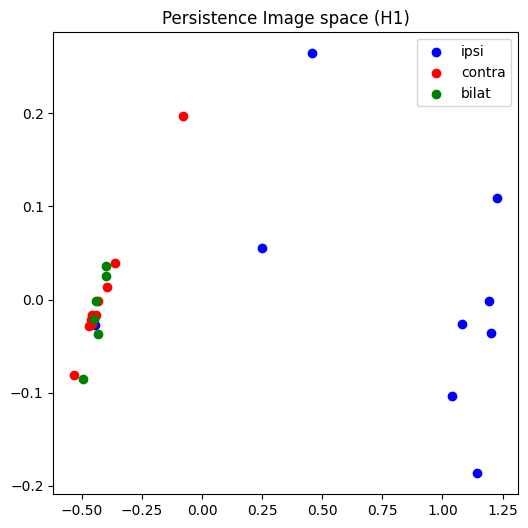

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

X = np.array([pimgr.transform(d).flatten() for d in all_h1_diagrams])
Xp = PCA(n_components=3).fit_transform(X)

plt.figure(figsize=(6, 6))
for label, name, c in [
    (0, "ipsi", "blue"),
    (1, "contra", "red"),
    (2, "bilat", "green"),
]:
    idx = y == label
    plt.scatter(Xp[idx, 0], Xp[idx, 1], label=name, c=c)

plt.legend()
plt.title("Persistence Image space (H1)")
plt.show()

### H1

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin


class PersistenceImageTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, pixel_size=0.1):
        self.pixel_size = pixel_size
        self.pimgr = PersistenceImager(pixel_size=pixel_size)

    def fit(self, X, y=None):
        # X is a list of persistence diagrams
        self.pimgr.fit(X)
        return self

    def transform(self, X):
        return np.array([self.pimgr.transform(d).flatten() for d in X])

### H2

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline

X_h2 = []

# Initialize PersistenceImager
pimgr = PersistenceImager(pixel_size=0.1)

print(
    f"Labels: {len(y)} samples ({np.sum(y == 0)} ipsi, {np.sum(y == 1)} contra, {np.sum(y == 2)} bilat)"
)

# Split into train and test sets
X_train_h2, X_test_h2, y_train_h2, y_test_h2 = train_test_split(
    all_h2_diagrams, y, test_size=0.3, stratify=y
)

# Fit the PersistenceImager on all H1 diagrams to determine proper ranges
print("\nFitting PersistenceImager on train diagrams...")
pimgr.fit(X_train_h2)

X_train_h2 = [pimgr.transform(d).flatten() for d in X_train_h2]
X_test_h2 = [pimgr.transform(d).flatten() for d in X_test_h2]

# Train SVM classifier
print("\nTraining SVM classifier...")
clf = make_pipeline(StandardScaler(), SVC(kernel="linear"))
clf.fit(X_train_h2, y_train_h2)

# Evaluate on test set
y_pred_h2 = clf.predict(X_test_h2)
accuracy_h2 = clf.score(X_test_h2, y_test_h2)

print(f"\nTest Accuracy: {accuracy_h2:.4f}")
print("\nClassification Report:")
print(
    classification_report(
        y_test_h2, y_pred_h2, target_names=["Ipsi", "Contra", "Bilat"]
    )
)

pipe = Pipeline(
    [
        ("pi", PersistenceImageTransformer(pixel_size=0.1)),
        ("scaler", StandardScaler()),
        ("svm", SVC(kernel="linear")),
    ]
)


cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

scores = cross_val_score(
    pipe,
    all_h2_diagrams,  # raw diagrams
    y,
    cv=cv,
    scoring="accuracy",
)

print("CV accuracy:", scores.mean(), "+/-", scores.std())

Labels: 26 samples (10 ipsi, 10 contra, 6 bilat)

Fitting PersistenceImager on train diagrams...

Training SVM classifier...

Test Accuracy: 0.7500

Classification Report:
              precision    recall  f1-score   support

        Ipsi       1.00      1.00      1.00         3
      Contra       0.67      0.67      0.67         3
       Bilat       0.50      0.50      0.50         2

    accuracy                           0.75         8
   macro avg       0.72      0.72      0.72         8
weighted avg       0.75      0.75      0.75         8



/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  warnings.warn(


CV accuracy: 0.6833333333333333 +/- 0.24094720491334934


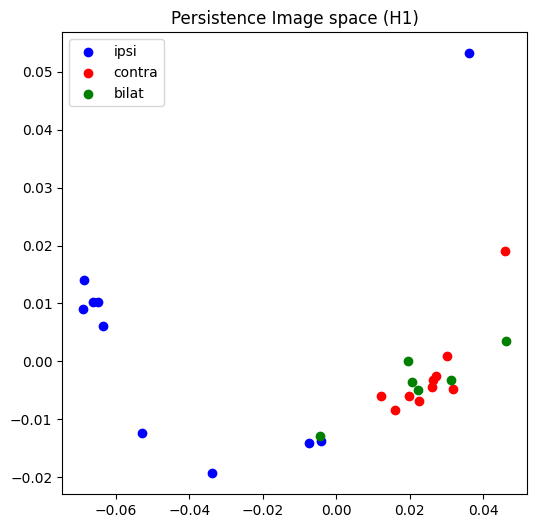

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

X = np.array([pimgr.transform(d).flatten() for d in all_h2_diagrams])
Xp = PCA(n_components=2).fit_transform(X)

plt.figure(figsize=(6, 6))
for label, name, c in [
    (0, "ipsi", "blue"),
    (1, "contra", "red"),
    (2, "bilat", "green"),
]:
    idx = y == label
    plt.scatter(Xp[idx, 0], Xp[idx, 1], label=name, c=c)

plt.legend()
plt.title("Persistence Image space (H1)")
plt.show()